In [54]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import col
from pyspark.sql.functions import col, avg, udf, when
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType


In [55]:
spark = SparkSession.builder \
    .appName("categorie immat") \
    .config("spark.hadoop.hive.metastore.uris", "thrift://hive-metastore:9083") \
    .enableHiveSupport() \
    .getOrCreate()

In [56]:
spark.sql("USE concessionnaire")
immatriculation_df = spark.sql("SELECT * FROM client_immatriculation_merged")

In [57]:
immatriculation_df.show(20)

+---------------+---+-----+----+-------------------+---------------+---------------+--------+---------+-----------+--------+--------+-------+--------+-------+------+
|immatriculation|age| sexe|taux|situationfamilliale|nbenfantacharge|deuxiemevoiture|  marque|puissance|   longueur|nbplaces|nbportes|couleur|occasion|   prix|modele|
+---------------+---+-----+----+-------------------+---------------+---------------+--------+---------+-----------+--------+--------+-------+--------+-------+------+
|        0 UI 76| 61|Homme| 419|          En Couple|              4|           true|Mercedes|      306|très longue|       5|       5|  rouge|    true|70910.0|  S500|
|       10 IM 37| 20|Homme|1245|          En Couple|              2|          false|  Jaguar|      197|     longue|       5|       5|   bleu|   false|37100.0|X-Type|
|       10 LB 49| 21|Homme| 502|          En Couple|              2|          false|   Volvo|      272|très longue|       5|       5|  rouge|   false|50500.0|   S80|
|   

In [58]:
length_mapping = {
    "courte": 1.0,
    "moyenne": 2.0,
    "longue": 3.0,
    "très longue": 4.0
}

situation_mapping = {
    "Célibataire": 0.0,
    "En Couple": 1.0
}


map_length = udf(lambda x: length_mapping.get(x, 0.0), DoubleType())
map_situation = udf(lambda x: situation_mapping.get(x, 0.0), DoubleType())

immatriculation_df = immatriculation_df.withColumn("longueur", map_length(col("longueur")))
immatriculation_df = immatriculation_df.withColumn("situationfamilliale", map_situation(col("situationfamilliale")))


In [59]:
immatriculation_df = immatriculation_df.withColumn("puissance", col("puissance").cast(DoubleType()))
immatriculation_df = immatriculation_df.withColumn("nbPortes", col("nbPortes").cast(DoubleType()))
immatriculation_df = immatriculation_df.withColumn("prix", col("prix").cast(DoubleType()))
immatriculation_df = immatriculation_df.withColumn("age", col("age").cast(DoubleType()))
immatriculation_df = immatriculation_df.withColumn("nbenfantacharge", col("nbenfantacharge").cast(DoubleType()))
immatriculation_df = immatriculation_df.withColumn("deuxiemevoiture",when(col("deuxiemevoiture") == "true", 1).when(col("deuxiemevoiture") == "false", 0).otherwise(None))

In [60]:
immatriculation_df.show(10)


+---------------+----+-----+----+-------------------+---------------+---------------+--------+---------+--------+--------+--------+-------+--------+-------+------+
|immatriculation| age| sexe|taux|situationfamilliale|nbenfantacharge|deuxiemevoiture|  marque|puissance|longueur|nbplaces|nbPortes|couleur|occasion|   prix|modele|
+---------------+----+-----+----+-------------------+---------------+---------------+--------+---------+--------+--------+--------+-------+--------+-------+------+
|        0 UI 76|61.0|Homme| 419|                1.0|            4.0|              1|Mercedes|    306.0|     4.0|       5|     5.0|  rouge|    true|70910.0|  S500|
|       10 IM 37|20.0|Homme|1245|                1.0|            2.0|              0|  Jaguar|    197.0|     3.0|       5|     5.0|   bleu|   false|37100.0|X-Type|
|       10 LB 49|21.0|Homme| 502|                1.0|            2.0|              0|   Volvo|    272.0|     4.0|       5|     5.0|  rouge|   false|50500.0|   S80|
|       10 MF 39

In [61]:
features_df = immatriculation_df.select("immatriculation", "puissance", "longueur", "nbPortes", "prix", "age", "nbenfantacharge", "situationfamilliale", "deuxiemevoiture")

In [62]:
assembler = VectorAssembler(inputCols=["puissance", "longueur", "nbPortes", "prix", "age", "nbenfantacharge", "situationfamilliale", "deuxiemevoiture"], outputCol="features", handleInvalid="skip")
assembled_df = assembler.transform(features_df)

In [63]:
features_df.select("puissance", "longueur", "nbPortes", "prix", "age", "nbenfantacharge", "situationfamilliale", "deuxiemevoiture").show(10)


+---------+--------+--------+-------+----+---------------+-------------------+---------------+
|puissance|longueur|nbPortes|   prix| age|nbenfantacharge|situationfamilliale|deuxiemevoiture|
+---------+--------+--------+-------+----+---------------+-------------------+---------------+
|    306.0|     4.0|     5.0|70910.0|61.0|            4.0|                1.0|              1|
|    197.0|     3.0|     5.0|37100.0|20.0|            2.0|                1.0|              0|
|    272.0|     4.0|     5.0|50500.0|21.0|            2.0|                1.0|              0|
|     75.0|     1.0|     5.0|18310.0|22.0|            0.0|                0.0|              0|
|    125.0|     3.0|     5.0|23900.0|41.0|            1.0|                1.0|              0|
|    507.0|     4.0|     5.0|94800.0|50.0|            1.0|                1.0|              0|
|    245.0|     4.0|     5.0|49200.0|36.0|            3.0|                1.0|              0|
|    125.0|     3.0|     5.0|16730.0|32.0|        

In [13]:
# Standardiser les caractéristiques pour les ramener à la même échelle
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(assembled_df)
scaled_df = scaler_model.transform(assembled_df)

In [14]:
k = 10
kmeans = KMeans(featuresCol="scaled_features", predictionCol="category", k=k)
model = kmeans.fit(scaled_df)

In [15]:
clustered_df = model.transform(scaled_df)

In [24]:
result_df = clustered_df.select("age", "longueur", "prix", "category", "features")
result_df.show(10)

+----+--------+-------+--------+--------------------+
| age|longueur|   prix|category|            features|
+----+--------+-------+--------+--------------------+
|61.0|     4.0|70910.0|       4|[306.0,4.0,5.0,70...|
|20.0|     3.0|37100.0|       5|[197.0,3.0,5.0,37...|
|21.0|     4.0|50500.0|       6|[272.0,4.0,5.0,50...|
|22.0|     1.0|18310.0|       7|[75.0,1.0,5.0,183...|
|41.0|     3.0|23900.0|       5|[125.0,3.0,5.0,23...|
|50.0|     4.0|94800.0|       9|[507.0,4.0,5.0,94...|
|36.0|     4.0|49200.0|       6|[245.0,4.0,5.0,49...|
|32.0|     3.0|16730.0|       5|[125.0,3.0,5.0,16...|
|26.0|     4.0|50500.0|       6|[272.0,4.0,5.0,50...|
|30.0|     1.0|13750.0|       3|[75.0,1.0,5.0,137...|
+----+--------+-------+--------+--------------------+
only showing top 10 rows

+---------------+---------+--------+--------+-------+----+---------------+-------------------+---------------+--------------------+--------------------+--------+
|immatriculation|puissance|longueur|nbPortes|   prix| ag

In [25]:
final_df = clustered_df.select(
    "immatriculation", 
    "puissance", 
    "longueur", 
    "nbPortes", 
    "prix", 
    "age", 
    "nbenfantacharge", 
    "situationfamilliale", 
    "deuxiemevoiture", 
    "category"
)

# Save
final_df.write.mode("overwrite").saveAsTable("client_vehicules_clusters_cleaned")

# Analyse des clusters

In [20]:
from pyspark.sql import functions as F

cluster_summary = clustered_df.groupBy("category").agg(
    F.avg("puissance").alias("moy_puissance"),
    F.avg("longueur").alias("moy_longueur"),
    F.avg("nbPortes").alias("moy_nbPortes"),
    F.avg("prix").alias("moy_prix"),
    F.avg("age").alias("moy_age"),
    F.avg("nbenfantacharge").alias("moy_nbenfantacharge")
)
cluster_summary.show()


+--------+------------------+------------------+------------+------------------+------------------+--------------------+
|category|     moy_puissance|      moy_longueur|moy_nbPortes|          moy_prix|           moy_age| moy_nbenfantacharge|
+--------+------------------+------------------+------------+------------------+------------------+--------------------+
|       1|58.765386204047914|               1.0|         3.0|10948.616274266831| 43.75051631557208|  0.9913258983890955|
|       6|240.23120798533307| 3.909553880627419|         5.0| 42166.39600733347| 36.40649826848645|  3.1459564066001224|
|       3| 76.18778105132579|               1.0|         5.0|14901.766940610947|44.406884788339276|  0.9979841835943557|
|       5|173.24005075556582|3.1370784788710733|         5.0| 29699.57611412312| 42.32406659745453|  0.9171761448840696|
|       9|             507.0|               4.0|         5.0| 84748.16921310607|  36.6975183255321|  2.4109334981895256|
|       4|355.44885945548197|   

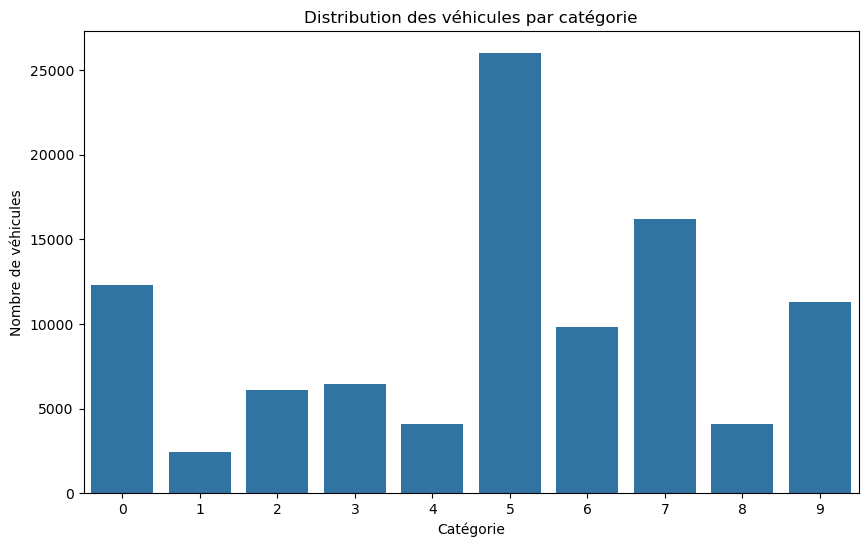

In [22]:
category_counts = result_df.groupBy("category").count().orderBy("category").collect()
categories = [row["category"] for row in category_counts]
counts = [row["count"] for row in category_counts]

plt.figure(figsize=(10, 6))
sns.barplot(x=categories, y=counts)
plt.xlabel("Catégorie")
plt.ylabel("Nombre de véhicules")
plt.title("Distribution des véhicules par catégorie")
plt.show()

In [ ]:
client_labeled_df.write.mode("overwrite").saveAsTable("client_immatriculation_with_labels")